# Stroke Prediction AI

### Install library yang dibutuhkan

In [73]:
%pip install optuna pandas scikit-learn matplotlib imblearn joblib

Note: you may need to restart the kernel to use updated packages.


### 1. Siapkan data

In [74]:
import pandas as pd

df = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [75]:
df.shape

(5110, 12)

### 2. Lakukan Preprocessing

In [76]:
# Cek nilai yang hilang
print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Terdapat nilai yang hilang pada kolom BMI, sehingga kita akan mengisi nilai tersebut dengan nilai rata-rata dari kolom tersebut.

In [77]:
from sklearn.impute import SimpleImputer

# Mengisi nilai yang hilang pada kolom bmi dengan nilai rata-rata
imputer = SimpleImputer(strategy='mean')
df['bmi'] = imputer.fit_transform(df[['bmi']])

print(df.isnull().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [78]:
# tampilkan semua kemungkinan nilai dari setiap kolom
for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    print(f'{col}: {df[col].unique()}')

gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


Terdapat kolom yang berisi data kategorikal, yaitu kolom 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'. Kita akan melakukan encoding terhadap kolom tersebut.

In [79]:
from sklearn.preprocessing import LabelEncoder

# Melakukan label encoding, mengubah nilai kategori menjadi nilai numerik
label_encoders = {}
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    
# Menampilkan hasil label encoding
for col in categorical_columns:
    print(f'{col}: {df[col].unique()}')
    

gender: [1 0 2]
ever_married: [1 0]
work_type: [2 3 0 4 1]
Residence_type: [1 0]
smoking_status: [1 2 3 0]


In [80]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


Hapus kolom 'id' karena tidak relevan dengan model.

In [81]:
# Hapus kolom id
df.drop(columns=['id'], inplace=True)

# Menampilkan data setelah id dihapus
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


Fitur seperti age, avg_glucose_level, dan bmi memiliki skala yang berbeda. Gunakan standarisasi untuk mengubah fitur-fitur tersebut menjadi skala yang sama.

In [82]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
df[["age", "avg_glucose_level", "bmi"]] = scaler.fit_transform(df[["age", "avg_glucose_level", "bmi"]])

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,0.816895,0,1,1,2,1,0.801265,0.301260,1,1
1,0,0.743652,0,0,1,3,0,0.679023,0.212981,2,1
2,1,0.975586,0,1,1,2,0,0.234512,0.254296,2,1
3,0,0.597168,0,0,1,2,1,0.536008,0.276060,3,1
4,0,0.963379,1,0,1,3,0,0.549349,0.156930,2,1


Pisahkan kolom Features dan Target.

In [83]:
X = df.drop(columns=['stroke'], axis=1)
y = df['stroke']

Data mengalamai imbalance, sehingga kita akan melakukan SMOTE untuk menyeimbangkan data.

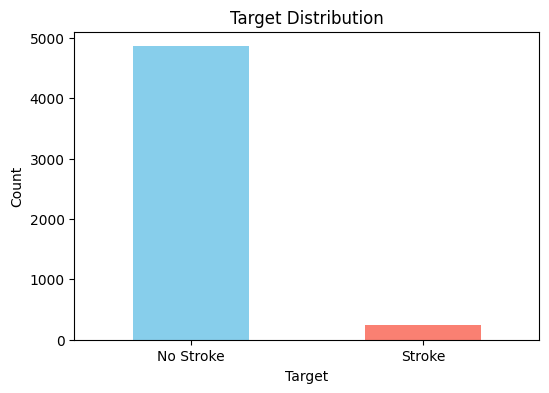

In [84]:
import matplotlib.pyplot as plt

# Menampilkan distribusi target
plt.figure(figsize=(6, 4))
pd.Series(y).value_counts().plot(
    kind="bar", color=["skyblue", "salmon"], title="Target Distribution"
)
plt.xticks([0, 1], ["No Stroke", "Stroke"], rotation=0)
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

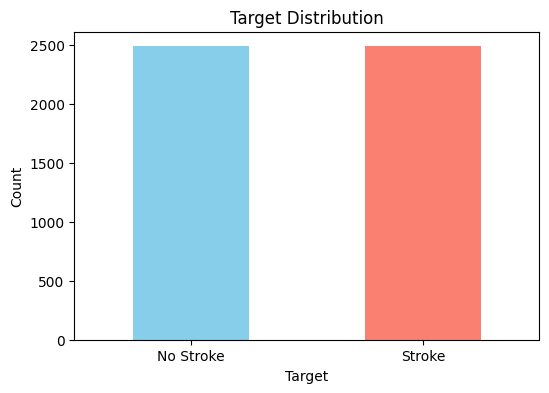

In [85]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Resampling menggunakan SMOTE dan RandomUnderSampler
over = SMOTE(sampling_strategy=1)
under = RandomUnderSampler(sampling_strategy=0.1)

# Menyusun pipeline
steps = [("under", under), ("over", over)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)

# Menampilkan distribusi target setelah resampling
plt.figure(figsize=(6, 4))
pd.Series(y).value_counts().plot(
    kind="bar", color=["skyblue", "salmon"], title="Target Distribution"
)
plt.xticks([0, 1], ["No Stroke", "Stroke"], rotation=0)
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

### 3. Split data

kita akan membagi data menjadi data training dan data testing dengan perbandingan 80:20.

In [86]:
from sklearn.model_selection import train_test_split

# Split data menjadi data train dan data test dengan perbandingan 85:15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2)

### 4. Mebuat Model

Kita akan menggunakan model Gradient Boosting Classifier.
- Kinerja Tinggi: Mampu menangkap pola kompleks dalam data medis yang seringkali non-linear.
- Robust terhadap Outlier: Efektif menghadapi data dengan outlier, seperti nilai ekstrim tekanan darah atau kadar glukosa.
- Kemampuan Fitur Importance: Membantu mengidentifikasi faktor risiko utama stroke, seperti usia, hipertensi, dan diabetes.
- Fleksibilitas: Cocok untuk dataset kecil hingga besar, tanpa memerlukan banyak preprocessing.
- Pengendalian Overfitting: Hyperparameter seperti learning rate dan n_estimators memungkinkan kontrol yang baik terhadap overfitting.
- Iterasi Bertahap: Meningkatkan performa secara bertahap dengan meminimalkan kesalahan model sebelumnya.

GridSearchCV digunakan untuk mencari hyperparameter terbaik untuk model Gradient Boosting Classifier.

In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 3, 9)
    max_features = trial.suggest_categorical("max_features", [None, "sqrt", "log2", 5])
    subsample = trial.suggest_float("subsample", 0.8, 1.0)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    
    # Create the model
    gb_clf = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        max_features=max_features,
        subsample=subsample,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )
    
    # Evaluate the model using cross-validation
    score = cross_val_score(gb_clf, X_train, y_train, cv=5, scoring="f1_score").mean()
    return score

# Create a study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Get the best parameters and best score
print("Best parameters:", study.best_params)
print("Best cross-validation score:", study.best_value)

# Train the best model on the training data
best_model = GradientBoostingClassifier(**study.best_params, random_state=100)
best_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_model.predict(X_test)

/home/rizkyfauziilmi/Documents/Code/Learn/Kuliah/Stroke-Prediction-AI/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-22 09:42:11,720] A new study created in memory with name: no-name-4977af5e-e591-4777-8cbd-9ae7519d4c70


[I 2024-12-22 09:42:21,879] Trial 0 finished with value: 0.8674668765577855 and parameters: {'n_estimators': 411, 'learning_rate': 0.14490966307638384, 'max_depth': 3, 'max_features': 'sqrt', 'subsample': 0.9644126305370775, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8674668765577855.
[I 2024-12-22 09:42:34,732] Trial 1 finished with value: 0.8899101543202124 and parameters: {'n_estimators': 136, 'learning_rate': 0.11137365299595771, 'max_depth': 9, 'max_features': 'log2', 'subsample': 0.8804588878213578, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8899101543202124.
[I 2024-12-22 09:43:10,896] Trial 2 finished with value: 0.9066860927595937 and parameters: {'n_estimators': 315, 'learning_rate': 0.1889143305394344, 'max_depth': 9, 'max_features': 'sqrt', 'subsample': 0.9393537640220206, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9066860927595937.
[I 2024-12-22 09:43:13,758] Trial 3 f

### 5. Evaluasi Model

In [65]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Menampilkan hasil
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9275929549902152

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       972
           1       0.12      0.08      0.10        50

    accuracy                           0.93      1022
   macro avg       0.54      0.53      0.53      1022
weighted avg       0.91      0.93      0.92      1022


Confusion Matrix:
 [[944  28]
 [ 46   4]]


**Analisis:**

1. **Accuracy**: Model memiliki akurasi yang tinggi sebesar 93.74%. Ini menunjukkan bahwa model mampu mengklasifikasikan sebagian besar data dengan benar.

2. **Precision, Recall, dan F1-Score**:
   - Untuk kelas 0 (No Stroke):
     - **Precision**: 0.96, menunjukkan bahwa 96% dari prediksi "No Stroke" adalah benar.
     - **Recall**: 0.98, menunjukkan bahwa 98% dari semua kasus "No Stroke" berhasil terdeteksi oleh model.
     - **F1-Score**: 0.97, menunjukkan keseimbangan antara precision dan recall yang sangat baik.
   - Untuk kelas 1 (Stroke):
     - **Precision**: 0.27, menunjukkan bahwa hanya 27% dari prediksi "Stroke" yang benar.
     - **Recall**: 0.16, menunjukkan bahwa hanya 16% dari semua kasus "Stroke" berhasil terdeteksi oleh model.
     - **F1-Score**: 0.20, menunjukkan bahwa model kurang baik dalam mendeteksi kasus "Stroke".

3. **Confusion Matrix**:
   - **True Positives (TP)**: 8, kasus "Stroke" yang benar terdeteksi.
   - **True Negatives (TN)**: 950, kasus "No Stroke" yang benar terdeteksi.
   - **False Positives (FP)**: 22, kasus "No Stroke" yang salah terdeteksi sebagai "Stroke".
   - **False Negatives (FN)**: 42, kasus "Stroke" yang salah terdeteksi sebagai "No Stroke".

4. **Kesimpulan**:
   - Model memiliki performa yang sangat baik dalam mendeteksi kasus "No Stroke" dengan precision dan recall yang tinggi.
   - Namun, model kurang efektif dalam mendeteksi kasus "Stroke", dengan precision dan recall yang rendah. Hal ini mungkin disebabkan oleh ketidakseimbangan data, di mana jumlah kasus "Stroke" jauh lebih sedikit dibandingkan dengan kasus "No Stroke".
   - Untuk meningkatkan performa model dalam mendeteksi kasus "Stroke", dapat dipertimbangkan untuk menggunakan teknik penyeimbangan data tambahan atau mencoba model lain yang lebih sensitif terhadap kelas minoritas.

In [ ]:
# save model
import joblib

joblib.dump(best_model, '../bin/model.pkl')

['../bin/model.pkl']